In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import pickle
import math
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tqdm import tqdm
from astropy.stats import sigma_clip

import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = 'L1495-B218_NH3_11.fits'
cube_11 = fits.open(path)
data_11 = cube_11[0].data
header_11 = cube_11[0].header
print(header_11[0:44])

wcs_nh3_11 = wcs.WCS(header_11)

print(wcs_nh3_11)
print(data_11.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    4 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                 1000                                                  NAXIS4  =                    1                                                  BLOCKED =                    T /Tape may be blocked                             OBJECT  = 'dtest   '           /Source name                                     TELESCOP= 'NRAO_GBT'           /                                                INSTRUME= 'RcvrArra'           /                                                OBSERVER= 'Yancy Sh'           /                                                DATE-OBS= '2012-04-25'         /Obs star

0.07728406227970908 kms


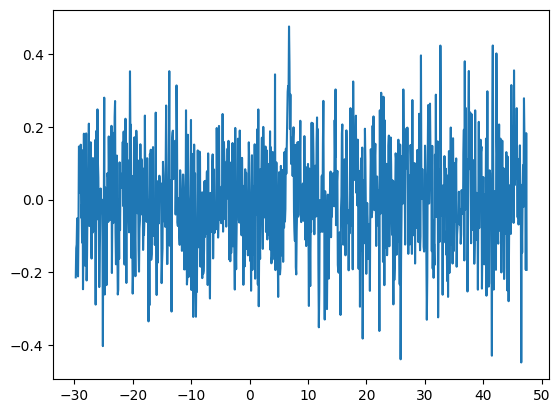

In [3]:
image = np.squeeze(data_11)

freq_start = header_11["CRVAL3"]
freq_inc = header_11["CDELT3"]

freq_channels = np.arange(header_11["NAXIS3"])

#define velocity as km/s blocks
frequency = freq_start + (freq_inc * freq_channels)
i_frequency = header_11["RESTFREQ"]

velocity = (3E8 * ((i_frequency - frequency)/i_frequency))/1000
velocity = np.array(velocity, dtype = float)
print(velocity[1] - velocity[0], 'kms')

plt.plot(velocity, image[:, 200, 1000])

In [4]:
path = 'HGBS_taurus_L1495_column_density_map.fits.gz'
cube_cd = fits.open(path)
data_cd = cube_cd[0].data
header_cd = cube_cd[0].header
print(header_cd)

wcs_cd = wcs.WCS(header_cd)

print(wcs_cd)
print(data_cd.shape)

SIMPLE  =                    T / Written by IDL:  Thu May  9 19:09:57 2019      BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    2 / Number of data axes                            NAXIS1  =                 8500 /Number of positions along axis 1                NAXIS2  =                 7200 /Number of positions along axis 2                CTYPE1  = 'RA---TAN'           / Coordinate Type                                CTYPE2  = 'DEC--TAN'           / Coordinate Type                                EQUINOX =                 2000 /Equinox of Ref. Coord.                          CDELT1  =         -0.000833333 / Degrees / Pixel                                CDELT2  =          0.000833333 / Degrees / Pixel                                CROTA2  =              0.00000 / Rotation Angle (Degrees)                       CRPIX1  =            4250.5000 / Reference Pixel in X                           CRPIX2  =            3600.5000 / Referen

## Calculating the Filament Masses

First from the column density maps, we calculate the mass, assuming the gas is entirely made of molecular hydrogen. Next, open up each of the individual maps to get the coordinates. Within those regions, sum up the mass for that region and convert to solar masses. If there is too low of a mass, this could explain why so far we aren't seeing as many obvious trends in the gradients -- there just isn't enough gravitational potential.

In [15]:
path = 'B10_velocity_posterior.fits'
cube_b10 = fits.open(path)
data_b10 = cube_b10[0].data
header_b10 = cube_b10[0].header
print(header_b10)

wcs_b10 = wcs.WCS(header_b10)

print(wcs_b10)
print(data_b10.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  169                                                  NAXIS2  =                  178                                                  NAXIS3  =                  199                                                  WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =               -693.0 / Pixel coordinate of reference point            CRPIX2  =               9601.0 / Pixel coordinate of reference point            CRPIX3  =                  0.0 / Pixel coordinate of reference point            CDELT1  =      -0.001666666707 / [deg] Coordinate increment at reference point  CDELT2  =       0.001666666707 / [deg] Coordinate increment at reference point  CDELT3  =    0.020100486924401 / [km/s] 

### Below is the code that was used to convert the boundaries of the sub-regions from galactic coordinates to equatorial

All of the information is saved in a pickle file so unless you want to have to reopen 6 different .fits files to be able to re-run this, I recommend you don't. Skip down about 6 cells and just work with the results from the .pkl file.

In [6]:
# Get the boundaries of the smaller cubes in galactic coordinates
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b7.wcs_pix2world([[0, 0, 0], [134, 168, 0]], 0)

# Convert the galactic coordinates to equatorial coordinates
c_1 = SkyCoord(l=l_min*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_1 = c_1.icrs
ra_1 = equatorial_1.ra*u.degree
dec_1 = equatorial_1.dec*u.degree

c_2 = SkyCoord(l=l_min*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_2 = c_2.icrs
ra_2 = equatorial_2.ra*u.degree
dec_2 = equatorial_2.dec*u.degree

c_3 = SkyCoord(l=l_max*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_3 = c_3.icrs
ra_3 = equatorial_3.ra*u.degree
dec_3 = equatorial_3.dec*u.degree

c_4 = SkyCoord(l=l_max*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_4 = c_4.icrs
ra_4 = equatorial_4.ra*u.degree
dec_4 = equatorial_4.dec*u.degree

# Find the pixel values in the new map in pixels

(ra_21_pix, dec_21_pix), (ra_22_pix, dec_22_pix), (ra_23_pix, dec_23_pix), (ra_24_pix, dec_24_pix) = wcs_cd.wcs_world2pix(
    [[ra_1.value, dec_1.value], [ra_2.value, dec_2.value], [ra_3.value, dec_3.value], [ra_4.value, dec_4.value],], 0)

In [8]:
# Get the boundaries of the smaller cubes in galactic coordinates
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b218.wcs_pix2world([[0, 0, 0], [172, 162, 0]], 0)

# Convert the galactic coordinates to equatorial coordinates
c_1 = SkyCoord(l=l_min*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_1 = c_1.icrs
ra_1 = equatorial_1.ra*u.degree
dec_1 = equatorial_1.dec*u.degree

c_2 = SkyCoord(l=l_min*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_2 = c_2.icrs
ra_2 = equatorial_2.ra*u.degree
dec_2 = equatorial_2.dec*u.degree

c_3 = SkyCoord(l=l_max*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_3 = c_3.icrs
ra_3 = equatorial_3.ra*u.degree
dec_3 = equatorial_3.dec*u.degree

c_4 = SkyCoord(l=l_max*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_4 = c_4.icrs
ra_4 = equatorial_4.ra*u.degree
dec_4 = equatorial_4.dec*u.degree

# Find the pixel values in the new map in pixels

(ra_17_pix, dec_17_pix), (ra_18_pix, dec_18_pix), (ra_19_pix, dec_19_pix), (ra_20_pix, dec_20_pix) = wcs_cd.wcs_world2pix(
    [[ra_1.value, dec_1.value], [ra_2.value, dec_2.value], [ra_3.value, dec_3.value], [ra_4.value, dec_4.value],], 0)

In [10]:
# Get the boundaries of the smaller cubes in galactic coordinates
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b216.wcs_pix2world([[0, 0, 0], [248, 168, 0]], 0)

# Convert the galactic coordinates to equatorial coordinates
c_1 = SkyCoord(l=l_min*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_1 = c_1.icrs
ra_1 = equatorial_1.ra*u.degree
dec_1 = equatorial_1.dec*u.degree

c_2 = SkyCoord(l=l_min*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_2 = c_2.icrs
ra_2 = equatorial_2.ra*u.degree
dec_2 = equatorial_2.dec*u.degree

c_3 = SkyCoord(l=l_max*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_3 = c_3.icrs
ra_3 = equatorial_3.ra*u.degree
dec_3 = equatorial_3.dec*u.degree

c_4 = SkyCoord(l=l_max*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_4 = c_4.icrs
ra_4 = equatorial_4.ra*u.degree
dec_4 = equatorial_4.dec*u.degree

# Find the pixel values in the new map in pixels

(ra_13_pix, dec_13_pix), (ra_14_pix, dec_14_pix), (ra_15_pix, dec_15_pix), (ra_16_pix, dec_16_pix) = wcs_cd.wcs_world2pix(
    [[ra_1.value, dec_1.value], [ra_2.value, dec_2.value], [ra_3.value, dec_3.value], [ra_4.value, dec_4.value],], 0)

In [12]:
# Get the boundaries of the smaller cubes in galactic coordinates
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b211.wcs_pix2world([[0, 0, 0], [352, 132, 0]], 0)

# Convert the galactic coordinates to equatorial coordinates
c_1 = SkyCoord(l=l_min*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_1 = c_1.icrs
ra_1 = equatorial_1.ra*u.degree
dec_1 = equatorial_1.dec*u.degree

c_2 = SkyCoord(l=l_min*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_2 = c_2.icrs
ra_2 = equatorial_2.ra*u.degree
dec_2 = equatorial_2.dec*u.degree

c_3 = SkyCoord(l=l_max*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_3 = c_3.icrs
ra_3 = equatorial_3.ra*u.degree
dec_3 = equatorial_3.dec*u.degree

c_4 = SkyCoord(l=l_max*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_4 = c_4.icrs
ra_4 = equatorial_4.ra*u.degree
dec_4 = equatorial_4.dec*u.degree

# Find the pixel values in the new map in pixels

(ra_9_pix, dec_9_pix), (ra_10_pix, dec_10_pix), (ra_11_pix, dec_11_pix), (ra_12_pix, dec_12_pix) = wcs_cd.wcs_world2pix(
    [[ra_1.value, dec_1.value], [ra_2.value, dec_2.value], [ra_3.value, dec_3.value], [ra_4.value, dec_4.value],], 0)

In [14]:
# Get the boundaries of the smaller cubes in galactic coordinates
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b213.wcs_pix2world([[0, 0, 0], [375, 150, 0]], 0)

# Convert the galactic coordinates to equatorial coordinates
c_1 = SkyCoord(l=l_min*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_1 = c_1.icrs
ra_1 = equatorial_1.ra*u.degree
dec_1 = equatorial_1.dec*u.degree

c_2 = SkyCoord(l=l_min*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_2 = c_2.icrs
ra_2 = equatorial_2.ra*u.degree
dec_2 = equatorial_2.dec*u.degree

c_3 = SkyCoord(l=l_max*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_3 = c_3.icrs
ra_3 = equatorial_3.ra*u.degree
dec_3 = equatorial_3.dec*u.degree

c_4 = SkyCoord(l=l_max*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_4 = c_4.icrs
ra_4 = equatorial_4.ra*u.degree
dec_4 = equatorial_4.dec*u.degree

# Find the pixel values in the new map in pixels

(ra_5_pix, dec_5_pix), (ra_6_pix, dec_6_pix), (ra_7_pix, dec_7_pix), (ra_8_pix, dec_8_pix) = wcs_cd.wcs_world2pix(
    [[ra_1.value, dec_1.value], [ra_2.value, dec_2.value], [ra_3.value, dec_3.value], [ra_4.value, dec_4.value],], 0)


In [16]:
# Get the boundaries of the smaller cubes in galactic coordinates
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b10.wcs_pix2world([[0, 0, 0], [180, 180, 0]], 0)

# Convert the galactic coordinates to equatorial coordinates
c_1 = SkyCoord(l=l_min*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_1 = c_1.icrs
ra_1 = equatorial_1.ra*u.degree
dec_1 = equatorial_1.dec*u.degree

c_2 = SkyCoord(l=l_min*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_2 = c_2.icrs
ra_2 = equatorial_2.ra*u.degree
dec_2 = equatorial_2.dec*u.degree

c_3 = SkyCoord(l=l_max*u.degree, b=b_max*u.degree, frame='galactic')
equatorial_3 = c_3.icrs
ra_3 = equatorial_3.ra*u.degree
dec_3 = equatorial_3.dec*u.degree

c_4 = SkyCoord(l=l_max*u.degree, b=b_min*u.degree, frame='galactic')
equatorial_4 = c_4.icrs
ra_4 = equatorial_4.ra*u.degree
dec_4 = equatorial_4.dec*u.degree

# Find the pixel values in the new map in pixels

(ra_1_pix, dec_1_pix), (ra_2_pix, dec_2_pix), (ra_3_pix, dec_3_pix), (ra_4_pix, dec_4_pix) = wcs_cd.wcs_world2pix(
    [[ra_1.value, dec_1.value], [ra_2.value, dec_2.value], [ra_3.value, dec_3.value], [ra_4.value, dec_4.value],], 0)

In [17]:
eq_boundaries = pd.DataFrame(data = {'Source': ['B10', 'B213', 'B211', 'B216', 'B218', 'B7'], 
                                    'Right Ascension 1': [ra_1_pix, ra_5_pix, ra_9_pix, ra_13_pix, ra_17_pix, ra_21_pix],
                                    'Declination 1': [dec_1_pix, dec_5_pix, dec_9_pix, dec_13_pix, dec_17_pix, dec_21_pix], 
                                    'Right Ascension 2': [ra_2_pix, ra_6_pix, ra_10_pix, ra_14_pix, ra_18_pix, ra_22_pix],
                                    'Declination 2': [dec_2_pix, dec_6_pix, dec_10_pix, dec_14_pix, dec_18_pix, dec_22_pix], 
                                    'Right Ascension 3': [ra_3_pix, ra_7_pix, ra_11_pix, ra_15_pix, ra_19_pix, ra_23_pix],
                                    'Declination 3': [dec_3_pix, dec_7_pix, dec_11_pix, dec_15_pix, dec_19_pix, dec_23_pix], 
                                    'Right Ascension 4': [ra_4_pix, ra_8_pix, ra_12_pix, ra_16_pix, ra_20_pix, ra_24_pix],
                                    'Declination 4': [dec_4_pix, dec_8_pix, dec_12_pix, dec_16_pix, dec_20_pix, dec_24_pix]})

with open('eq_boundaries.pkl', 'wb') as f:  # open a text file
    pickle.dump(eq_boundaries, f) # serialize the list
f.close()

### Now you can start running this code to open and use the .pkl files

,Source,Right Ascension 1,Declination 1,Right Ascension 2,Declination 2,Right Ascension 3,Declination 3,Right Ascension 4,Declination 4
0,B10,4934.074724,3779.736514,4671.601226,4026.151477,4916.814309,4286.961067,5178.942637,4040.148025
1,B213,4091.440463,2542.465862,3871.455831,2746.499588,4382.416645,3295.749940,4601.756690,3091.058713
2,B211,4643.899220,2960.301418,4450.824382,3140.382694,4931.318926,3654.047241,5123.879031,3473.406858
3,B216,3256.449768,2045.376685,3009.140969,2273.005314,3346.555583,2638.841914,3593.360521,2410.748616
4,B218,2241.224832,1758.429859,2001.835335,1977.153206,2236.138362,2233.075241,2475.173769,2014.054434
5,B7,4771.746898,4167.801609,4526.927425,4397.966091,4709.169207,4591.626637,4953.751331,4361.185024


4934.074723760313
2742.217
0.004183924


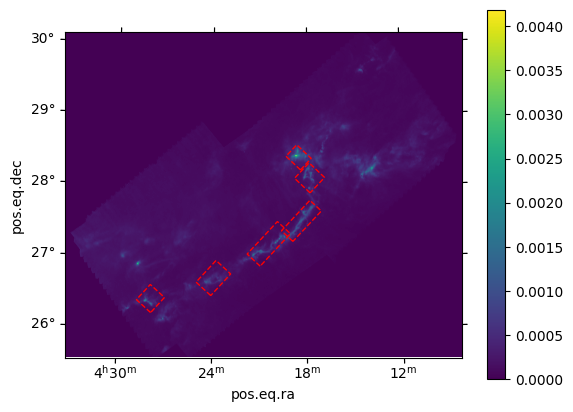

In [5]:
with open('eq_boundaries.pkl', 'rb') as f:
    coordinates_info = pickle.load(f)
    
display(coordinates_info)

print(coordinates_info.iloc[0, 1])

ax = plt.subplot(111, projection = wcs_cd)

mH2 = 2.809 * 1.6735575E-24
cm2_per_pix = 3.94857E31
solar_masses_g = 1.989E33
mass = mH2 * data_cd * cm2_per_pix / solar_masses_g

print(np.nansum(mass))

plt.imshow(mass, origin = 'lower', vmin = 0)
plt.colorbar()
plt.xlim(800, 7500)
plt.ylim(1000, 6500)

ax.add_patch(plt.Polygon([(coordinates_info.iloc[0, 1], coordinates_info.iloc[0, 2]), 
                          (coordinates_info.iloc[0, 3], coordinates_info.iloc[0, 4]), 
                          (coordinates_info.iloc[0, 5], coordinates_info.iloc[0, 6]), 
                          (coordinates_info.iloc[0, 7], coordinates_info.iloc[0, 8])],
                         ls="--", ec="r", fc="none"))
ax.add_patch(plt.Polygon([(coordinates_info.iloc[1, 1], coordinates_info.iloc[1, 2]), 
                          (coordinates_info.iloc[1, 3], coordinates_info.iloc[1, 4]), 
                          (coordinates_info.iloc[1, 5], coordinates_info.iloc[1, 6]), 
                          (coordinates_info.iloc[1, 7], coordinates_info.iloc[1, 8])],
                         ls="--", ec="r", fc="none"))
ax.add_patch(plt.Polygon([(coordinates_info.iloc[2, 1], coordinates_info.iloc[2, 2]), 
                          (coordinates_info.iloc[2, 3], coordinates_info.iloc[2, 4]), 
                          (coordinates_info.iloc[2, 5], coordinates_info.iloc[2, 6]), 
                          (coordinates_info.iloc[2, 7], coordinates_info.iloc[2, 8])],
                         ls="--", ec="r", fc="none"))
ax.add_patch(plt.Polygon([(coordinates_info.iloc[3, 1], coordinates_info.iloc[3, 2]), 
                          (coordinates_info.iloc[3, 3], coordinates_info.iloc[3, 4]), 
                          (coordinates_info.iloc[3, 5], coordinates_info.iloc[3, 6]), 
                          (coordinates_info.iloc[3, 7], coordinates_info.iloc[3, 8])],
                         ls="--", ec="r", fc="none"))
ax.add_patch(plt.Polygon([(coordinates_info.iloc[4, 1], coordinates_info.iloc[4, 2]), 
                          (coordinates_info.iloc[4, 3], coordinates_info.iloc[4, 4]), 
                          (coordinates_info.iloc[4, 5], coordinates_info.iloc[4, 6]), 
                          (coordinates_info.iloc[4, 7], coordinates_info.iloc[4, 8])],
                         ls="--", ec="r", fc="none"))
ax.add_patch(plt.Polygon([(coordinates_info.iloc[5, 1], coordinates_info.iloc[5, 2]), 
                          (coordinates_info.iloc[5, 3], coordinates_info.iloc[5, 4]), 
                          (coordinates_info.iloc[5, 5], coordinates_info.iloc[5, 6]), 
                          (coordinates_info.iloc[5, 7], coordinates_info.iloc[5, 8])],
                         ls="--", ec="r", fc="none"))

print(np.max(mass))

65.564766 0.0
Total H2 Mass in Taurus: 585173.097


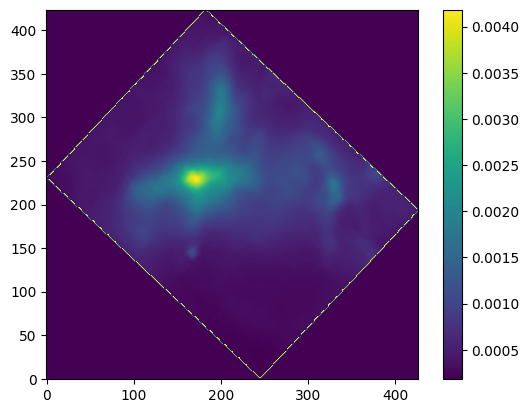

In [6]:
import matplotlib.path

a = 5

temp_list = [[coordinates_info.iloc[a, 1], coordinates_info.iloc[a, 2]], [coordinates_info.iloc[a, 3], coordinates_info.iloc[a, 4]], 
           [coordinates_info.iloc[a, 5], coordinates_info.iloc[a, 6]], [coordinates_info.iloc[a, 7], coordinates_info.iloc[a, 8]]]

polygon = np.array(temp_list)
left = np.min(polygon, axis=0)
right = np.max(polygon, axis=0)

x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)

xv, yv = np.meshgrid(x, y, indexing='xy')
points = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = xv.shape

mass_1 = mass[:, np.arange(x[0], x[-1]+1)]
mass_2 = mass_1[np.arange(y[0], y[-1]+1), :]

plt.imshow(mask, origin = 'lower')
mass_masked = np.ma.array(mass_2, mask = ~mask)
plt.imshow(mass_masked, origin = 'lower')
plt.colorbar()

greater_05 = []
for i in range(len(mass_masked)):
    row = mass_masked[i]
    
    floats = row[row == row.astype(float)]
    for j in range(len(floats)):
        if floats[j] > 0.5:
            greater_05.append(floats[j])

print(np.sum(mass_masked), np.sum(greater_05))

print('Total H2 Mass in Taurus:', 84955.83 + 122841.914 + 122789.65 + 65338.953 + 46730.73 + 142516.02)

## Average Column Density and Mass along the Filaments

I want to see if there is an inherent difference to the environments that the Class 1 Spines trace compared to the Class 2, 3, and 4 spines. First, we need to import the spines files (currently in a pickle file), then convert those pixel coordinates to galactic coordinates and then to equatorial coordinates and finally to the pixel coordinates in the column density wcs. Then, find the nearest whole pixel for each of those. And then either find the average column density or the median (or some other statistical measurement) to see if there is an acutal relationship there.

In [7]:
path = 'velocity_grid.fits'
cube = fits.open(path)
velocity_grid_data = cube[0].data
header = cube[0].header
#print(header)

wcs_vel_grid = wcs.WCS(header)

print(wcs_vel_grid)
print(velocity_grid_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)


In [8]:
with open('spines_coordinates.pkl', 'rb') as f:
    coordinates_info = pickle.load(f)

long = np.array(coordinates_info['Galactic Longitude'])
lat = np.array(coordinates_info['Galactic Latitude'])

equatorial_ra_pix = []
equatorial_dec_pix = []
for i in range(len(long)):
    l, b, vel = wcs_vel_grid.wcs_pix2world(long[i], lat[i], np.zeros(len(long[i])), 0)

    galactic_frame = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic')
    equatorial_frame = galactic_frame.icrs
    ra = equatorial_frame.ra*u.degree
    dec = equatorial_frame.dec*u.degree

    ra_pixels, dec_pixels = wcs_cd.wcs_world2pix(ra.value, dec.value, 0)
    equatorial_ra_pix.append(ra_pixels)
    equatorial_dec_pix.append(dec_pixels)

(1200.0, 5000.0)

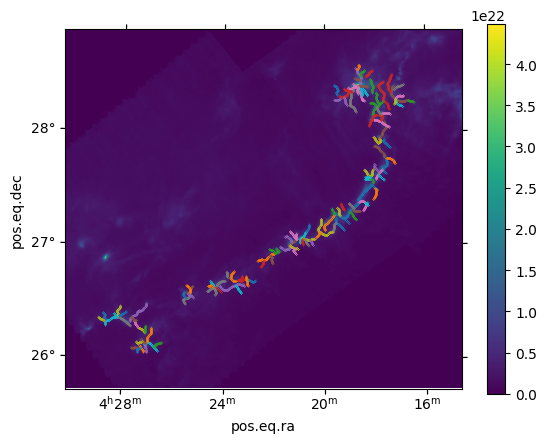

In [9]:
ax = plt.subplot(111, projection = wcs_cd)

plt.imshow(data_cd, origin = 'lower', vmin = 0)
plt.colorbar()

for i in range(len(equatorial_ra_pix)):
    ax.scatter(equatorial_ra_pix[i], equatorial_dec_pix[i], s = 0.01)

plt.xlim(1600, 5800)
plt.ylim(1200, 5000)

In [10]:
rounded_ra_pix = []
rounded_dec_pix = []

for i in range(len(equatorial_ra_pix)):
    rounded_ra = []
    rounded_dec = []
    for j in range(len(equatorial_ra_pix[i])):
        rounded_ra.append(round(equatorial_ra_pix[i][j]))
        rounded_dec.append(round(equatorial_dec_pix[i][j]))
        
    rounded_ra_pix.append(rounded_ra)
    rounded_dec_pix.append(rounded_dec)

In [38]:
print(rounded_ra_pix[0][0], rounded_dec_pix[0][0])
print(data_cd[3005, 4539])

column_densities = []
avg_cd = []
med_cd = []
std_cd = []
for i in range(len(equatorial_ra_pix)):
    spine_cd = []
    for j in range(len(equatorial_ra_pix[i])):
        spine_cd.append(data_cd[rounded_dec_pix[i][j], rounded_ra_pix[i][j]])
    column_densities.append(spine_cd)
    avg_cd.append(np.mean(spine_cd))
    med_cd.append(np.median(spine_cd))
    std_cd.append(np.sqrt(np.sum(abs((spine_cd - np.mean(spine_cd))/1E20)**2)/len(spine_cd))*1E20)
print(std_cd)

np.sqrt(np.sum(abs(spine_cd - np.mean(spine_cd))**2)/len(spine_cd))

4539 3005
9.894125e+21
[np.float32(2.7608133e+21), np.float32(4.7623534e+21), np.float32(2.7762355e+21), np.float32(1.6588104e+21), np.float32(2.0358643e+21), np.float32(2.240925e+21), np.float32(1.1706434e+22), np.float32(2.9151674e+21), np.float32(1.981618e+21), np.float32(5.644717e+21), np.float32(3.9641672e+21), np.float32(1.1987542e+21), np.float32(2.793334e+21), np.float32(1.89873e+21), np.float32(6.719606e+21), np.float32(3.135133e+21), np.float32(3.1715686e+21), np.float32(3.7899212e+21), np.float32(4.566363e+21), np.float32(1.9870225e+21), np.float32(2.1036115e+21), np.float32(6.3914994e+20), np.float32(2.2511507e+21), np.float32(7.004915e+20), np.float32(1.0650118e+21), np.float32(9.3784704e+20), np.float32(3.614571e+21), np.float32(4.653705e+21), np.float32(2.7899453e+21), np.float32(4.5842405e+21), np.float32(6.7807076e+20), np.float32(1.1853941e+21), np.float32(3.49085e+21), np.float32(4.5779352e+21), np.float32(3.0136062e+21), np.float32(4.1896222e+21), np.float32(2.67919

/tmp/ipykernel_644551/2999472238.py:18: RuntimeWarning: overflow encountered in square
  np.sqrt(np.sum(abs(spine_cd - np.mean(spine_cd))**2)/len(spine_cd))


np.float32(inf)

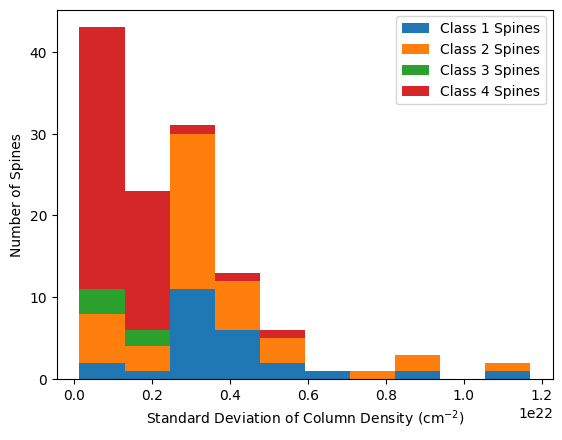

In [39]:
class1 = [0, 1, 6, 8, 9, 12, 14, 16, 18, 27, 28, 29, 32, 33, 35, 38, 42, 63, 65, 77, 91, 101, 102, 107, 113]
class2 = [2, 3, 7, 9, 15, 17, 26, 28, 30, 34, 36, 39, 41, 48, 52, 54, 56, 58, 68, 69, 70, 72, 77, 78, 79, 80, 82, 85, 86, 87, 93, 96, 97, 98, 99, 100, 
          111, 114, 115, 116, 119]
class3 = [57, 67, 73, 106, 109]
class4 = [4, 5, 10, 11, 13, 19, 20, 21, 22, 23, 24, 25, 31, 37, 40, 43, 44, 45, 46, 47, 49, 50, 51, 53, 55, 59, 60, 61, 62, 64, 66, 71, 74, 75, 76, 81, 
          83, 84, 88, 89, 90, 92, 94, 95, 103, 104, 105, 108, 110, 112, 117, 118]

class1_cd = []
for i in class1:
   class1_cd.append(std_cd[i])
class2_cd = []
for i in class2:
   class2_cd.append(std_cd[i])
class3_cd = []
for i in class3:
   class3_cd.append(std_cd[i])
class4_cd = []
for i in class4:
   class4_cd.append(std_cd[i])


plt.hist([class1_cd, class2_cd, class3_cd, class4_cd], bins = 10, stacked=True, label = ['Class 1 Spines', 'Class 2 Spines', 'Class 3 Spines', 'Class 4 Spines'])
plt.xlabel(r'Standard Deviation of Column Density (cm$^{-2}$)')
plt.ylabel('Number of Spines')
plt.legend()
#plt.grid()

In [49]:
path = 'HGBS_perseus_column_density_map.fits.gz'
cube_cd = fits.open(path)
data_cd = cube_cd[0].data
header_cd = cube_cd[0].header
print(header_cd)

wcs_cd = wcs.WCS(header_cd)

print(wcs_cd)
print(data_cd.shape)

SIMPLE  =                    T / Written by IDL:  Fri Sep 29 17:28:33 2017      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 7500                                                  NAXIS2  =                 6000                                                  COMMENT Science data image                                                      CREATOR = 'IDL               '                                                  TELESCOP= 'Herschel Space Observatory'                                          INSTRUME= 'SPIRE/PACS'                                                          PROPOSAL= 'KPGT_pandre_1'                                                       PRTITLE = 'Herschel Gould Belt Survey (HGBS)'                                   COMMENT Reference publication of the survey: Andre' et al. (2010)               COMMENT bibcode: 2010A&A...518L.102A    

26763308.0


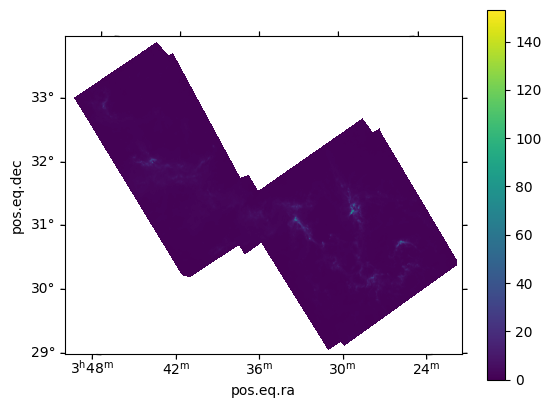

In [50]:
ax = plt.subplot(111, projection = wcs_cd)

mH2 = 2.016 * 1.6735575E-24
cm2_per_pix = 5.755E35
solar_masses_g = 1.989E33
mass = mH2 * data_cd * cm2_per_pix / solar_masses_g

print(np.nansum(mass))

plt.imshow(mass, origin = 'lower', vmin = 0)
plt.colorbar()

## Compairing the Svoboda Velocities with Seo Velocities

To make sure that Youngmin and Brian found roughly the same thing between whatever algorithm Youngmin used to get the maximum likelihood velocities and the Bayesian statistics that Brian used to get these velocities, we are going to take the ratio of the two. Ideally, most of the time, the ratios are right around 1. If there is some noteworthy difference, then that is something we want to look into and figure out what caused it.

In [47]:
path = 'NH3_v_lsr.fits'
cube_seo = fits.open(path)
data_seo = cube_seo[0].data
header_seo = cube_seo[0].header
print(header_seo[0:44])

wcs_seo = wcs.WCS(header_seo)

print(wcs_seo)
print(data_seo.shape)


path = 'velocity_grid.fits'
cube_svoboda = fits.open(path)
data_svoboda = cube_svoboda[0].data
header_svoboda = cube_svoboda[0].header
print(header_svoboda[0:44])

wcs_svoboda = wcs.WCS(header_svoboda)

print(wcs_svoboda)
print(data_svoboda.shape)

SIMPLE  =                    T / Written by IDL:  Sun Apr 14 07:20:33 2013      BITPIX  =                  -32 /                                                NAXIS   =                    2 /                                                NAXIS1  =                 2200 /Number of positions along axis 1                NAXIS2  =                  800 /Number of positions along axis 2                EXTEND  =                    T /Tables following main image                     BLOCKED =                    T /Tape may be blocked                             OBJECT  = 'dtest   '           /Source name                                     TELESCOP= 'NRAO_GBT'           /                                                INSTRUME= 'RcvrArra'           /                                                OBSERVER= 'Yancy Sh'           /                                                DATE-OBS= '2012-04-25'         /Obs start date YYYY-MM-DD                       DATE-MAP= '2013-03-08'         /Last pro

/home/ljsteffes/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/ljsteffes/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.        , 0.13418976, 0.26837952, 0.40256929, 0.53675905,
        0.67094881, 0.80513857, 0.93932833, 1.07351809, 1.20770786,
        1.34189762]),
 <a list of 2200 BarContainer objects>)

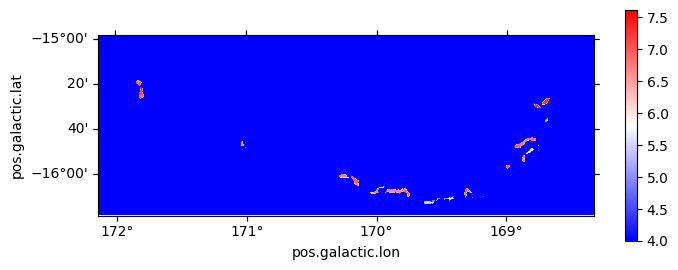

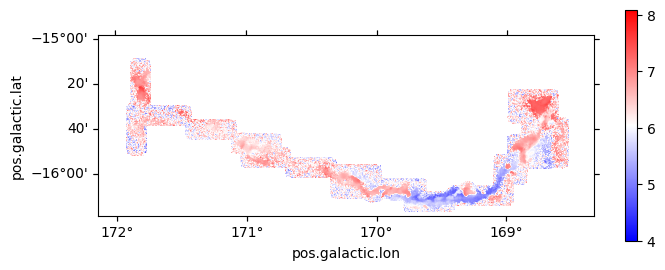

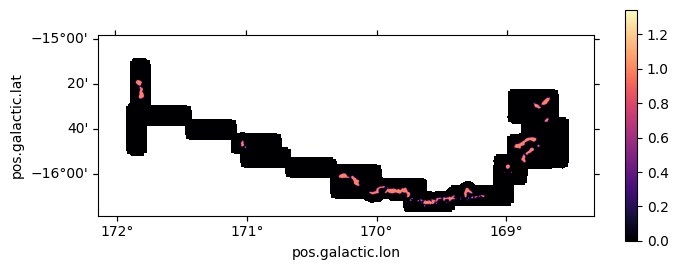

In [67]:
plt.figure(figsize = [8,3])
ax = plt.subplot(111, projection = wcs_seo, slices = ('x', 'y', 0, 0))
plt.imshow(data_seo/1E5, 'bwr', vmin = 4)
plt.colorbar()

plt.figure(figsize = [8,3])
ax = plt.subplot(111, projection = wcs_svoboda, slices = ('x', 'y', 0))
plt.imshow(data_svoboda, 'bwr', vmin = 4)
plt.colorbar()

ratio = data_seo/1E5/data_svoboda

plt.figure(figsize = [8,3])
ax = plt.subplot(111, projection = wcs_seo, slices = ('x', 'y', 0, 0))
plt.imshow(ratio, 'magma')
plt.colorbar()

0.7551110839976763
0.9916088183690595


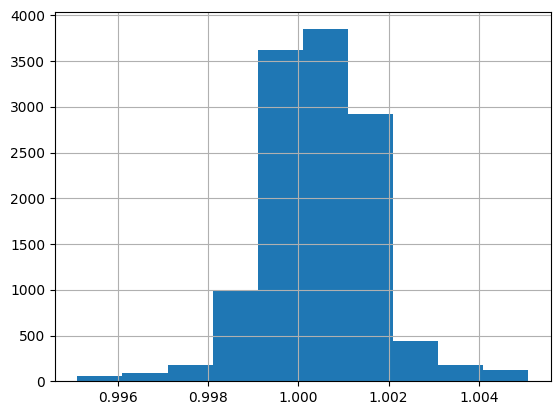

In [96]:
#print(ratio[0])

ratio_histogram = []
for i in range(len(ratio)):
    for j in range(len(ratio[i])):
        if ratio[i][j] == 0:
            continue
        elif math.isnan(ratio[i][j]) == True:
            continue
        else:
            ratio_histogram.append(ratio[i][j])

print(np.min(ratio_histogram))
print((12469 + 143 + 325 + 35 + 27)/len(ratio_histogram))

bins = np.arange(0.9951, 1.0056, 0.001)
plt.hist(ratio_histogram, bins)
plt.grid()


#plt.yscale('log')
#plt.xlabel(r'Ratio of Svoboda $v_{LSR}$ to Seo $v_{LSR}$')
#plt.ylabel('Abundance')

#plt.show()